## Import libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import tensorflow_addons as tfa

## Read Data Set

In [2]:
segmentations = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
segmentations['EncodedPixels'] = segmentations['EncodedPixels'].astype('string')

In [3]:
TRAIN_DIR = '/kaggle/input/airbus-ship-detection/train_v2/'
TEST_DIR = '/kaggle/input/airbus-ship-detection/test_v2/'

In [4]:
# Function to retrieve a training image based on its name
def get_train_image(name: str):
    # Construct the path to the image file
    path = f'/kaggle/input/airbus-ship-detection/train_v2/{name}'
    # Read and return the image using OpenCV
    return cv2.imread(path)

# Function to extract features from an image and update the given DataFrame row
def extract_features_from_image(row: pd.Series) -> pd.Series:
    # Initialize an empty image array (all black) with shape (768, 768, 3)
    image = np.zeros((768, 768, 3))  # This line is currently commented out: get_train_image(row['ImageId'])
    # Update the row with the image's height and width
    row['ImageHeight'], row['ImageWidth'], _ = image.shape
    return row

# Apply the extract_features_from_image function to each row in the 'segmentations' DataFrame
segmentations = segmentations.apply(lambda x: extract_features_from_image(x), axis=1)


### Define Variables

In [5]:
# Number of images without ships to include in the training dataset
IMAGES_WITHOUT_SHIPS_NUMBER = 25000

# Number of images reserved for validation
VALIDATION_LENGTH = 2000

# Number of images reserved for testing
TEST_LENGTH = 2000

# Batch size for training the model
BATCH_SIZE = 16

# Buffer size for shuffling the training dataset
BUFFER_SIZE = 1000

# Shape of the input images (height, width)
IMG_SHAPE = (256, 256)

# Number of classes in the segmentation task (typically foreground and background)
NUM_CLASSES = 2

random.seed(77)

## Utils

In [6]:
# Convert Run Length Encoded (RLE) format to binary mask
def rle_to_mask(rle: str, shape=(768, 768)):
    encoded_pixels = np.array(rle.split(), dtype=int)
    starts = encoded_pixels[::2] - 1
    ends = starts + encoded_pixels[1::2]
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T 

# Convert binary mask to Run Length Encoded (RLE) format
def mask_to_rle(img, shape=(768, 768)) -> str:
    img = img.astype('float32')
    img = cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    img = np.stack(np.vectorize(lambda x: 0 if x < 0.1 else 1)(img), axis=1)
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Convert integer labels to one-hot encoded array
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

# Function for making predictions using the trained model
def predict(image):
    image = np.expand_dims(image, axis=0)
    pred_mask = model.predict(image)[0].argmax(axis=-1)  
    return pred_mask


## Data preprocessing

In [7]:
df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv") # we will define the same ship segmentations dataset again
df['EncodedPixels'] = df['EncodedPixels'].astype('string')

# Delete corrupted images
CORRUPTED_IMAGES = ['6384c3e78.jpg']
df = df.drop(df[df['ImageId'].isin(CORRUPTED_IMAGES)].index)

# Dataframe that contains the segmentation for each ship in the image. 
instance_segmentation = df

# Dataframe that contains the segmentation of all ships in the image.
image_segmentation = df.groupby(by=['ImageId'])['EncodedPixels'].apply(lambda x: np.nan if pd.isna(x).any() else ' '.join(x)).reset_index()

In [8]:
# reduce the number of images without ships
images_without_ships = image_segmentation[image_segmentation['EncodedPixels'].isna()]['ImageId'].values[:IMAGES_WITHOUT_SHIPS_NUMBER]
images_with_ships = image_segmentation[image_segmentation['EncodedPixels'].notna()]['ImageId'].values
images_list = np.append(images_without_ships, images_with_ships)

# remove corrupted images
images_list = np.array(list(filter(lambda x: x not in CORRUPTED_IMAGES, images_list)))

In [9]:
# One last variable
# Calculate the number of images for training based on the total images and validation/test set sizes
TRAIN_LENGTH = len(images_list) - VALIDATION_LENGTH - TEST_LENGTH

In [10]:
# Function to load training images along with masks and sample weights
def load_train_image(tensor) -> tuple:
    # Extract file path from the Tensor and decode it
    path = tf.get_static_value(tensor).decode("utf-8")

    # Extract image ID from the path
    image_id = path.split('/')[-1]
    
    # Read the input image using OpenCV
    input_image = cv2.imread(path)
    
    # Resize the image to the specified shape
    input_image = tf.image.resize(input_image, IMG_SHAPE)
    
    # Normalize pixel values to the range [0, 1]
    input_image = tf.cast(input_image, tf.float32) / 255.0

    # Extract the encoded mask for the corresponding image ID
    encoded_mask = image_segmentation[image_segmentation['ImageId'] == image_id].iloc[0]['EncodedPixels']
    
    # Initialize an empty mask array
    input_mask = np.zeros(IMG_SHAPE + (1,), dtype=np.int8)
    
    # If the encoded mask is not empty, convert it to a binary mask
    if not pd.isna(encoded_mask):
        input_mask = rle_to_mask(encoded_mask)
        input_mask = cv2.resize(input_mask, IMG_SHAPE, interpolation=cv2.INTER_AREA)
        input_mask = np.expand_dims(input_mask, axis=2)
    
    # Convert the binary mask to one-hot encoding
    one_hot_segmentation_mask = one_hot(input_mask, NUM_CLASSES)
    
    # Convert the one-hot encoded mask to a TensorFlow tensor
    input_mask_tensor = tf.convert_to_tensor(one_hot_segmentation_mask, dtype=tf.float32)
    
    # Define class weights for the segmentation classes
    class_weights = tf.constant([0.0005, 0.9995], tf.float32)
    
    # Gather sample weights based on the input mask
    sample_weights = tf.gather(class_weights, indices=tf.cast(input_mask_tensor, tf.int32), name='cast_sample_weights')

    # Return the input image, input mask tensor, and sample weights
    return input_image, input_mask_tensor, sample_weights

# Create a TensorFlow dataset for the list of image files
images_list = tf.data.Dataset.list_files([f'{TRAIN_DIR}{name}' for name in images_list], shuffle=True)

# Map the load_train_image function to create a dataset of image, mask, and sample weight tuples
train_images = images_list.map(lambda x: tf.py_function(load_train_image, [x], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)

# Split the dataset into training, validation, and test sets
validation_dataset = train_images.take(VALIDATION_LENGTH)
test_dataset = train_images.skip(VALIDATION_LENGTH).take(TEST_LENGTH)
train_dataset = train_images.skip(VALIDATION_LENGTH + TEST_LENGTH)

# Create batches of training, validation, and test datasets
train_batches = (
    train_dataset
    .repeat()
    .batch(BATCH_SIZE))

validation_batches = validation_dataset.batch(BATCH_SIZE)

test_batches = test_dataset.batch(BATCH_SIZE)


## UNet segmentation model

In [11]:
# Dice coefficient metric for model evaluation
def dice_coef(y_true, y_pred, smooth=1e-6):
    # Calculate the intersection between true and predicted masks
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    
    # Calculate the union of true and predicted masks
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    
    # Calculate the Dice coefficient with smoothing
    dice = (2. * intersection + smooth) / (union + smooth)
    
    # Return the mean Dice coefficient across all batches
    return tf.reduce_mean(dice)

# Dice loss function for model training
def dice_loss(y_true, y_pred):
    # Calculate the Dice coefficient
    dice_coef_val = dice_coef(y_true, y_pred)
    
    # Return the complement of the Dice coefficient as the loss
    return 1 - dice_coef_val


In [12]:
class UNetModel:
    def __init__(self, input_shape=(128, 128, 3), num_classes=NUM_CLASSES):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self._model = self._build_model()

    @property
    def model(self) -> tf.keras.Model:
        return self._model

    def _conv_block(self, x, filters, size, apply_batch_norm=False, apply_instance_norm=False, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters, size, strides=1, padding='same', use_bias=False, kernel_initializer=initializer),
            tf.keras.layers.BatchNormalization() if apply_batch_norm else tf.keras.layers.Lambda(lambda x: x),
            tfa.layers.InstanceNormalization() if apply_instance_norm else tf.keras.layers.Lambda(lambda x: x),
            tf.keras.layers.Activation(tfa.activations.mish),
            tf.keras.layers.Dropout(0.55) if apply_dropout else tf.keras.layers.Lambda(lambda x: x),
        ])
        return result(x)

    def _upsample_block(self, x, filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False, kernel_initializer=initializer),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.1) if apply_dropout else tf.keras.layers.Lambda(lambda x: x),
            tf.keras.layers.Activation(tfa.activations.mish),
        ])
        return result(x)

    def _build_model(self):
        inputs = tf.keras.layers.Input(shape=self.input_shape)
        x = inputs
        filters_list = [16, 32, 64]

        # Encoder
        encoder_outputs = []
        for i, filters in enumerate(filters_list):
            x = self._conv_block(x, filters, size=3, apply_batch_norm=True, apply_instance_norm=True)
            print(f"Encoder Block {i+1} Output Shape: {x.shape}")
            x = self._conv_block(x, filters, size=1, apply_batch_norm=True, apply_instance_norm=True)
            encoder_outputs.append(x)
            x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

        x = self._conv_block(x, filters=128, size=3, apply_batch_norm=True)
        print(f"Encoder Block {len(filters_list)+1} Output Shape: {x.shape}")
        encoder_outputs.append(x)

        # Decoder
        x = encoder_outputs[-1]
        for i, (filters, skip) in enumerate(zip(filters_list[::-1], encoder_outputs[-2::-1])):
            x = self._upsample_block(x, filters, 3)
            print(f"Decoder Upsample Block {i+1} Output Shape: {x.shape}")
            x = tf.keras.layers.Concatenate()([x, skip])
            print(f"Decoder Concatenate Block {i+1} Output Shape: {x.shape}")
            x = self._conv_block(x, filters, size=3, apply_batch_norm=True)
            print(f"Decoder Conv Block {i+1} Output Shape: {x.shape}")
            x = self._conv_block(x, filters, size=1, apply_batch_norm=True)
            print(f"Decoder Conv Block {i+1} Output Shape: {x.shape}")

        # Output layer
        last = self._conv_block(x, filters=self.num_classes, size=1)
        print(f"Output Block Output Shape: {last.shape}")
        outputs = tf.keras.layers.Activation('softmax')(last)

        return tf.keras.Model(inputs=inputs, outputs=outputs)

### 1. U-Net Architecture
The U-Net architecture is commonly used for image segmentation tasks, where the goal is to classify each pixel in an image into a specific class. It consists of an encoder-decoder structure with skip connections.

### 2. Model Class: `UNetModel`
- **Initialization**: The class is initialized with parameters like `input_shape` (default is (128, 128, 3)) and `num_classes` (default is `NUM_CLASSES`). It creates an instance variable `_model` by calling the `_build_model` method.

- **Properties**:
  - `model`: Returns the internal Keras model.

### 3. Model Architecture:
- **Encoder Blocks**:
  - The encoder consists of convolutional blocks with increasing filters and downsampling through max-pooling.
  - Batch normalization, instance normalization, Mish activation, and dropout are applied in each block.

- **Decoder Blocks**:
  - The decoder consists of upsampling blocks that mirror the encoder.
  - Concatenation is performed with skip connections from the corresponding encoder block.
  - Batch normalization, Mish activation, and dropout are applied in each block.

- **Output Layer**:
  - The final layer is a convolutional block with softmax activation to produce pixel-wise class probabilities.

### 4. Printing Output Shapes:
- The code includes print statements to display the output shapes after each block, aiding in understanding the network's architecture.

### 5. Custom Layers and Activations:
- The model uses Mish activation from the `tfa.activations` module.
- It also uses Instance Normalization from the `tfa.layers` module.

### 6. Dropout and Initialization:
- Dropout is applied with a rate of 0.55 during encoding and 0.1 during decoding.
- Convolutional layers use a random normal initializer with a mean of 0 and standard deviation of 0.02.

In [13]:
# Number of training epochs
EPOCHS = 4

# Calculate steps per epoch based on training length and batch size
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Define the RectifiedAdam optimizer with learning rate schedule
optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=0.005,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_proportion=0.3,
    min_lr=0.00001,
)

# Apply Lookahead optimization technique to the optimizer
optimizer = tfa.optimizers.Lookahead(optimizer)

# Define Categorical Crossentropy loss function
loss = tf.keras.losses.CategoricalCrossentropy()

# Instantiate the UNetModel and get the underlying model
model = UNetModel(IMG_SHAPE + (3,)).model

# Compile the model with the specified optimizer, loss function, and evaluation metric (dice_coef)
model.compile(optimizer=optimizer, 
              loss=loss,  # Alternatively, use dice_loss as the loss function
              metrics=[dice_coef],
)

# Calculate the number of trainable parameters in the model
trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])

# Print the total number of trainable parameters in the model
print(f'Trainable params: {trainable_params}')

Encoder Block 1 Output Shape: (None, 256, 256, 16)
Encoder Block 2 Output Shape: (None, 128, 128, 32)
Encoder Block 3 Output Shape: (None, 64, 64, 64)
Encoder Block 4 Output Shape: (None, 32, 32, 128)
Decoder Upsample Block 1 Output Shape: (None, 64, 64, 64)
Decoder Concatenate Block 1 Output Shape: (None, 64, 64, 128)
Decoder Conv Block 1 Output Shape: (None, 64, 64, 64)
Decoder Conv Block 1 Output Shape: (None, 64, 64, 64)
Decoder Upsample Block 2 Output Shape: (None, 128, 128, 32)
Decoder Concatenate Block 2 Output Shape: (None, 128, 128, 64)
Decoder Conv Block 2 Output Shape: (None, 128, 128, 32)
Decoder Conv Block 2 Output Shape: (None, 128, 128, 32)
Decoder Upsample Block 3 Output Shape: (None, 256, 256, 16)
Decoder Concatenate Block 3 Output Shape: (None, 256, 256, 32)
Decoder Conv Block 3 Output Shape: (None, 256, 256, 16)
Decoder Conv Block 3 Output Shape: (None, 256, 256, 16)
Output Block Output Shape: (None, 256, 256, 2)
Trainable params: 303344


In [14]:
# Define the filepath for model checkpoints
checkpoint_filepath = 'checkpoints/model-checkpoint'

# Create a ModelCheckpoint callback to save the best model based on validation dice coefficient
save_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_dice_coef',  # Monitor validation dice coefficient
    mode='max',  # Save when the monitored quantity is maximized
    save_best_only=True  # Save only the best model
)

# Train the model using the training batches and validate on validation batches
model_history = model.fit(
    train_batches,  # Training dataset
    epochs=EPOCHS,  # Number of training epochs
    steps_per_epoch=STEPS_PER_EPOCH,  # Number of steps per training epoch
    validation_data=validation_batches,  # Validation dataset
    callbacks=[save_callback]  # List of callbacks, including ModelCheckpoint
)

# Load the weights of the best model based on validation dice coefficient
model.load_weights(checkpoint_filepath)

Epoch 1/4
3972/3972 [==============================] - 2772s 658ms/step - loss: 0.1506 - dice_coef: 0.8837 - val_loss: 0.0047 - val_dice_coef: 0.9975
Epoch 2/4
3972/3972 [==============================] - 2591s 619ms/step - loss: 0.0045 - dice_coef: 0.9976 - val_loss: 0.0043 - val_dice_coef: 0.9978
Epoch 3/4
3972/3972 [==============================] - 2591s 620ms/step - loss: 0.0035 - dice_coef: 0.9981 - val_loss: 0.0027 - val_dice_coef: 0.9984
Epoch 4/4
3972/3972 [==============================] - 2593s 620ms/step - loss: 0.0028 - dice_coef: 0.9985 - val_loss: 0.0022 - val_dice_coef: 0.9987


## Plot loss/metric

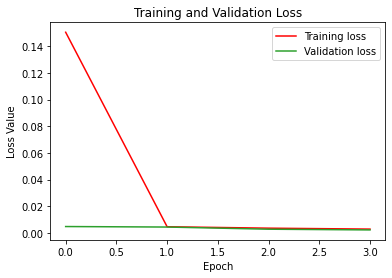

In [15]:
# Extract training and validation loss from the model history
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plotting the training and validation loss over epochs
plt.figure()

# Plot training loss in red
plt.plot(model_history.epoch, loss, 'r', label='Training loss')

# Plot validation loss in green
plt.plot(model_history.epoch, val_loss, 'C2', label='Validation loss')

# Set the title and labels for the plot
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')

# Add a legend to distinguish between training and validation loss
plt.legend()

# Display the plot
plt.show()

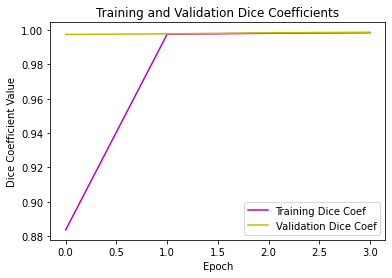

In [16]:
# Same idea as last cell with dice score
dice_coef_values = model_history.history['dice_coef']
val_dice_coef_values = model_history.history['val_dice_coef']

plt.figure()
plt.plot(model_history.epoch, dice_coef_values, 'm', label='Training Dice Coef')
plt.plot(model_history.epoch, val_dice_coef_values, 'y', label='Validation Dice Coef')

plt.title('Training and Validation Dice Coefficients')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient Value')
plt.legend()
plt.show()

# Results visualization

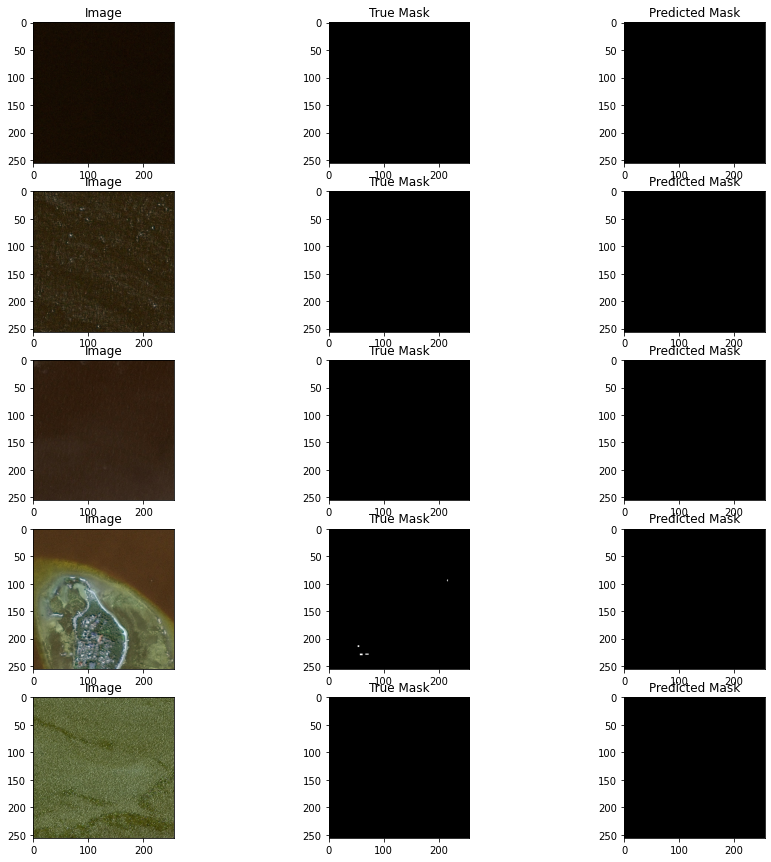

In [17]:
f, ax = plt.subplots(5, 3, figsize=(15, 15))
i = 0

# Iterate over the first 5 samples in the test dataset
for image, mask in test_dataset.take(5):
    mask = mask.numpy().argmax(axis=-1)

    # Plot the original image
    ax[i, 0].imshow(image)
    ax[i, 0].set_title('Image')

    # Plot the true mask (ground truth)
    ax[i, 1].imshow(mask, cmap='gray')
    ax[i, 1].set_title('True Mask')

    # Predict the mask using the 'predict' function and plot the result
    pred_mask = predict(image)
    ax[i, 2].imshow(pred_mask, cmap='gray')
    ax[i, 2].set_title('Predicted Mask')

    i += 1

plt.show()

In [18]:
results = model.evaluate(test_batches)
print("test loss, test dice:", results)

125/125 [==============================] - 136s 562ms/step - loss: 0.0024 - dice_coef: 0.9987
test loss, test dice: [0.0024330164305865765, 0.998661458492279]


In [19]:
# dice_metric = dice_coef 
# dice_results = []

# for image, true_mask in test_dataset.take(TEST_LENGTH):
#     true_mask = true_mask.numpy().argmax(axis=-1)
#     pred_mask = predict(image)
    
#     dice_value = dice_metric(true_mask, pred_mask)
#     dice_results.append(dice_value)

# plt.hist(dice_results, bins=15)
# print("Mean Dice Coefficient:", np.mean(dice_results))


# Submission

In [20]:
# Load the sample submission file
submission = pd.read_csv("/kaggle/input/airbus-ship-detection/sample_submission_v2.csv")

# Function to set model predictions for each row in the submission file
def set_model_prediction(row: pd.Series) -> pd.Series:
    # Read and preprocess the image
    image = cv2.imread(f'{TEST_DIR}{row["ImageId"]}')
    image = cv2.resize(image, IMG_SHAPE, interpolation=cv2.INTER_AREA)
    image = image / 255.0
    
    # Generate predictions using the model
    pred_mask = predict(image)
    
    # Convert the predicted mask to run-length encoding
    row['EncodedPixels'] = mask_to_rle(pred_mask)
    
    # If the predicted mask is empty, set the 'EncodedPixels' to NaN
    if row['EncodedPixels'] == '':
        row['EncodedPixels'] = np.nan
    
    return row

# Apply the set_model_prediction function to each row in the submission DataFrame
submission = submission.apply(lambda x: set_model_prediction(x), axis=1)

# Set the 'ImageId' column as the index
submission = submission.set_index("ImageId")

# Save the submission DataFrame to a CSV file
submission.to_csv("submission.csv")
submission


,EncodedPixels
ImageId,
00002bd58.jpg,NaN
00015efb6.jpg,NaN
00023d5fc.jpg,NaN
000367c13.jpg,90337 9 91105 9 91873 9 92638 15 93406 15 9417...
0008ca6e9.jpg,NaN
...,...
ffdb3cda6.jpg,NaN
ffe3857eb.jpg,NaN
ffeb765e8.jpg,290464 6 291232 6 292000 6 299665 9 300433 9 3...
